In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# I want to load a csv placed in ../logs/log_ear_mar.csv
# with this header timestamp;path_img;ear;mar

# And load into a dataframe using pandas

file_path = "../logs/log_ear_mar.csv"

df = pd.read_csv(file_path, sep=";")

In [6]:
df['category'] = df['path_img'].apply(lambda x: x.split('/')[2])
df

# cast ear and mar to float
df['ear'] = df['ear'].astype(float)
df['mar'] = df['mar'].astype(float)

['bostezo', 'ojos_cerrados', 'ojos_abiertos', 'boca_cerrada']

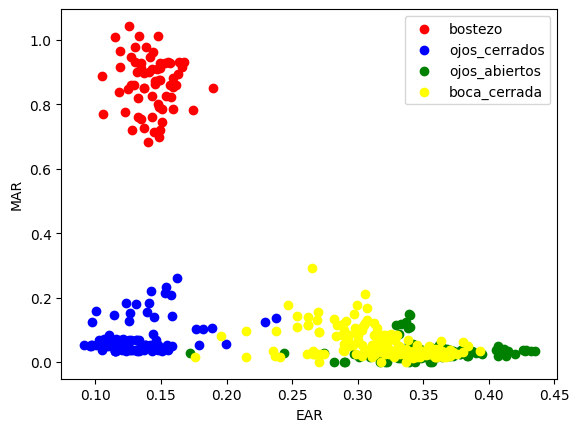

In [19]:
# plot ear vs mar, coloring different categories
colors = {
    'bostezo': 'red',
    'ojos_cerrados': 'blue',
    'ojos_abiertos': 'green',
    'boca_cerrada': 'yellow',
}

# Plot a scatter plot with labels per category
for category in colors.keys():
    plt.scatter(df[df['category'] == category]['ear'], df[df['category'] == category]['mar'], c=colors[category], label=category)

plt.xlabel('EAR')
plt.ylabel('MAR')
plt.legend()
plt.show()


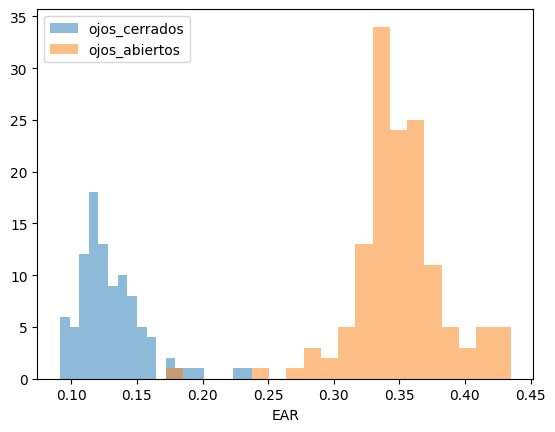

In [18]:
# Create a distribution plot for categories ojos_cerrados and ojos_abiertos for EAR
plt.hist(df[df['category'] == 'ojos_cerrados']['ear'], bins=20, alpha=0.5, label='ojos_cerrados')
plt.hist(df[df['category'] == 'ojos_abiertos']['ear'], bins=20, alpha=0.5, label='ojos_abiertos')
plt.xlabel('EAR')
plt.legend()
plt.show()

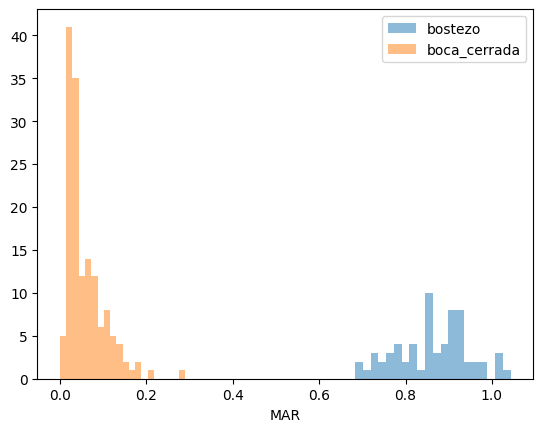

In [17]:
# Create a distribution plot for categories bostezo and boca_cerrada for MAR
plt.hist(df[df['category'] == 'bostezo']['mar'], bins=20, alpha=0.5, label='bostezo')
plt.hist(df[df['category'] == 'boca_cerrada']['mar'], bins=20, alpha=0.5, label='boca_cerrada')
plt.xlabel('MAR')
plt.legend()